Running MC Exploring Starts...
Value at (0,0): 0.296
Value at (0,1) [Blue]: 2.933

🧭 MC - Exploring Starts - Policy:
 →  ↑  →  ↓  → 
 ↓  ↓  ←  ↓  ↓ 
 T  ←  →  →  T 
 ↓  ↓  ←  ↑  ↑ 
 T  ←  ←  ↑  ↓ 


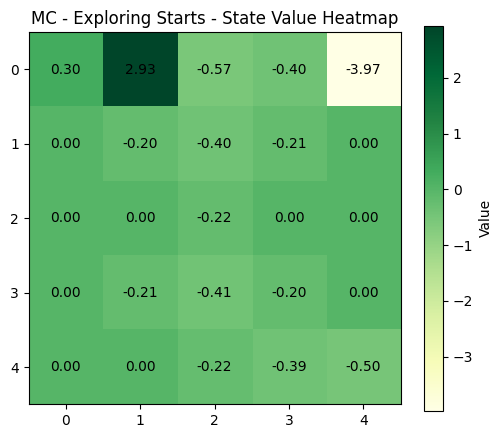

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Environment Settings ===
grid_size = 5
gamma = 0.95
epsilon = 0.9
MAX_STEPS = 100
terminal_states = [(2, 0), (2, 4), (4, 0)]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
action_to_idx = {a: i for i, a in enumerate(actions)}

def step(state, action):
    blue = (0, 1)
    green = (0, 4)
    red = (4, 2)
    yellow = (4, 4)

    if state in terminal_states:
        return state, 0, True
    if state == blue:
        return red, 5, False
    if state == green:
        next_state = random.choice([red, yellow])
        return next_state, 2.5, False

    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    if not (0 <= nr < grid_size and 0 <= nc < grid_size):
        return state, -0.5, False

    next_state = (nr, nc)
    if next_state in terminal_states:
        return next_state, 0, True

    return next_state, -0.2, False

# === MC Exploring Starts ===
def mc_exploring_starts(num_episodes=5000):
    Q = np.zeros((grid_size, grid_size, len(actions)))
    Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]
    policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)

    for ep in range(num_episodes):
        # Avoid terminal start
        while True:
            s = (random.randrange(grid_size), random.randrange(grid_size))
            if s not in terminal_states:
                break
        a = actions[random.randrange(len(actions))]
        episode = []
        state, action = s, a
        done, t = False, 0
        while not done and t < MAX_STEPS:
            ns, r, done = step(state, action)
            episode.append((state, action, r))
            state = ns
            if done:
                break
            action = actions[np.argmax(policy[state[0], state[1]])]
            t += 1

        G = 0
        visited = set()
        for st, ac, rew in reversed(episode):
            G = gamma * G + rew
            idx = st[0]*grid_size + st[1]
            ai = action_to_idx[ac]
            if (st, ai) not in visited:
                Returns[idx][ai].append(G)
                Q[st[0], st[1], ai] = np.mean(Returns[idx][ai])
                visited.add((st, ai))

        for r in range(grid_size):
            for c in range(grid_size):
                best_a = np.flatnonzero(Q[r, c] == Q[r, c].max())
                policy[r, c] = np.zeros(len(actions))
                policy[r, c][random.choice(best_a)] = 1.0

    print(f"Value at (0,0): {np.max(Q[0,0]):.3f}")
    print(f"Value at (0,1) [Blue]: {np.max(Q[0,1]):.3f}")
    return policy, Q

# === Visualization ===
def plot_policy_and_values(policy, Q, title=""):
    syms = ['↑', '↓', '←', '→']
    V = np.max(Q, axis=2)
    print(f"\n🧭 {title} - Policy:")
    for r in range(grid_size):
        row = ''
        for c in range(grid_size):
            if (r, c) in terminal_states:
                row += ' T '
            else:
                row += f' {syms[np.argmax(policy[r, c])]} '
        print(row)

    plt.figure(figsize=(6, 5))
    plt.imshow(V, cmap='YlGn', origin='upper')
    plt.colorbar(label='Value')
    plt.title(f'{title} - State Value Heatmap')
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{V[i,j]:.2f}", ha='center', va='center', color='black')
    plt.xticks(np.arange(grid_size))
    plt.yticks(np.arange(grid_size))
    plt.grid(False)
    plt.show()

# === Run All ===
print("Running MC Exploring Starts...")
policy_es, Q_es = mc_exploring_starts()
plot_policy_and_values(policy_es, Q_es, "MC - Exploring Starts")



Running MC ε-Soft...
Value at (0,0): 3.252
Value at (0,1) [Blue]: 3.627

🧭 MC - ε-Soft - Policy:
 →  ↑  ←  ←  ↑ 
 ↑  ↑  ↑  ←  ↑ 
 T  ↑  ↑  →  T 
 ↑  ↑  ↑  ↑  ↑ 
 T  ←  ←  ↑  ↑ 


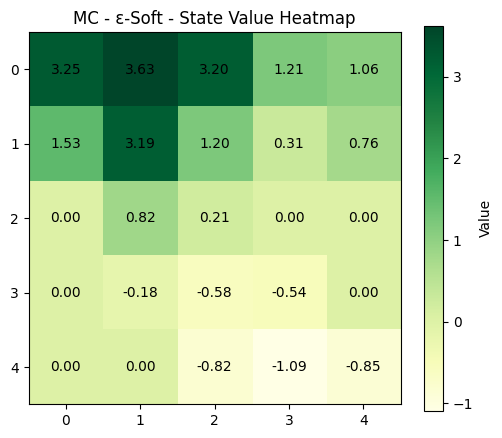

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Environment Settings ===
grid_size = 5
gamma = 0.95
epsilon = 0.9
MAX_STEPS = 100
terminal_states = [(2, 0), (2, 4), (4, 0)]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_to_idx = {a: i for i, a in enumerate(actions)}

def step(state, action):
    blue = (0, 1)
    green = (0, 4)
    red = (4, 2)
    yellow = (4, 4)

    if state in terminal_states:
        return state, 0, True
    if state == blue:
        return red, 5, False
    if state == green:
        next_state = random.choice([red, yellow])
        return next_state, 2.5, False

    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    if not (0 <= nr < grid_size and 0 <= nc < grid_size):
        return state, -0.5, False

    next_state = (nr, nc)
    if next_state in terminal_states:
        return next_state, 0, True

    return next_state, -0.2, False

def mc_eps_soft(num_episodes=10000):
    Q = np.zeros((grid_size, grid_size, len(actions)))
    Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]
    policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)

    for ep in range(num_episodes):
        while True:
            state = (random.randrange(grid_size), random.randrange(grid_size))
            if state not in terminal_states:
                break

        episode = []
        done, t = False, 0
        while not done and t < MAX_STEPS:
            if random.random() < epsilon:
                action = actions[random.randrange(len(actions))]
            else:
                action = actions[np.argmax(Q[state[0], state[1]])]
            ns, r, done = step(state, action)
            episode.append((state, action, r))
            state = ns
            t += 1

        G = 0
        visited = set()
        for st, ac, rew in reversed(episode):
            G = gamma * G + rew
            idx = st[0]*grid_size + st[1]
            ai = action_to_idx[ac]
            if (st, ai) not in visited:
                Returns[idx][ai].append(G)
                Q[st[0], st[1], ai] = np.mean(Returns[idx][ai])
                visited.add((st, ai))

                best = np.argmax(Q[st[0], st[1]])
                for i in range(len(actions)):
                    policy[st[0], st[1], i] = epsilon / len(actions)
                policy[st[0], st[1], best] += (1 - epsilon)

    print(f"Value at (0,0): {np.max(Q[0,0]):.3f}")
    print(f"Value at (0,1) [Blue]: {np.max(Q[0,1]):.3f}")
    return policy, Q

def plot_policy_and_values(policy, Q, title=""):
    syms = ['↑', '↓', '←', '→']
    V = np.max(Q, axis=2)
    print(f"\n {title} - Policy:")
    for r in range(grid_size):
        row = ''
        for c in range(grid_size):
            if (r, c) in terminal_states:
                row += ' T '
            else:
                row += f' {syms[np.argmax(policy[r, c])]} '
        print(row)

    plt.figure(figsize=(6, 5))
    plt.imshow(V, cmap='YlGn', origin='upper')
    plt.colorbar(label='Value')
    plt.title(f'{title} - State Value Heatmap')
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{V[i,j]:.2f}", ha='center', va='center', color='black')
    plt.xticks(np.arange(grid_size))
    plt.yticks(np.arange(grid_size))
    plt.grid(False)
    plt.show()

# === Run ===
print("Running MC ε-Soft...")
policy_eps, Q_eps = mc_eps_soft()
plot_policy_and_values(policy_eps, Q_eps, "MC - ε-Soft")



🧭 MC - Weighted IS - Policy:
 →  →  ←  ←  ← 
 →  ↑  ←  ←  ↑ 
 T  ↑  ↑  ↓  T 
 →  ↑  ↑  ←  ← 
 T  ←  →  →  ↓ 


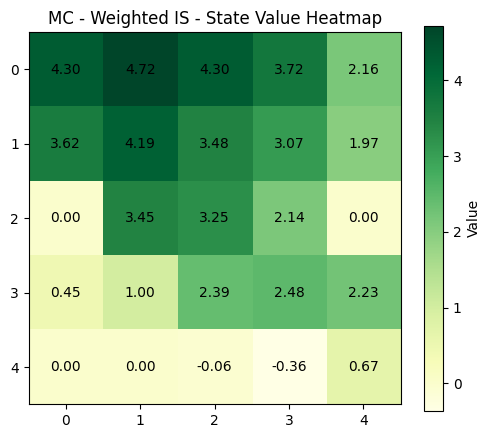

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Environment Settings ===
grid_size = 5
gamma = 0.95
epsilon = 0.9
MAX_STEPS = 100
terminal_states = [(2, 0), (2, 4), (4, 0)]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_to_idx = {a: i for i, a in enumerate(actions)}

def step(state, action):
    blue = (0, 1)
    green = (0, 4)
    red = (4, 2)
    yellow = (4, 4)

    if state in terminal_states:
        return state, 0, True
    if state == blue:
        return red, 5, False
    if state == green:
        next_state = random.choice([red, yellow])
        return next_state, 2.5, False

    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    if not (0 <= nr < grid_size and 0 <= nc < grid_size):
        return state, -0.5, False

    next_state = (nr, nc)
    if next_state in terminal_states:
        return next_state, 0, True

    return next_state, -0.2, False
def mc_off_policy_weighted_is(num_episodes=20000, epsilon=0.1):
    Q = np.zeros((grid_size, grid_size, len(actions)))
    C = np.zeros((grid_size, grid_size, len(actions)))  # Cumulative weight
    target_policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)

    for ep in range(num_episodes):
        # Start from a non-terminal state
        while True:
            s = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
            if s not in terminal_states:
                break

        episode = []
        state = s
        t, done = 0, False
        while not done and t < MAX_STEPS:
            action = random.choice(actions)  # behavior policy = uniform random
            next_state, reward, done = step(state, action)
            episode.append((state, action, reward))
            state = next_state
            t += 1

        G = 0
        W = 1.0

        for state, action, reward in reversed(episode):
            i, j = state
            a_idx = action_to_idx[action]
            G = gamma * G + reward

            C[i, j, a_idx] += W
            Q[i, j, a_idx] += (W / C[i, j, a_idx]) * (G - Q[i, j, a_idx])

            # Update target policy to ε-greedy
            best_a = np.argmax(Q[i, j])
            for a in range(len(actions)):
                if a == best_a:
                    target_policy[i, j, a] = 1 - epsilon + epsilon / len(actions)
                else:
                    target_policy[i, j, a] = epsilon / len(actions)

            pi_a = target_policy[i, j, a_idx]
            b_a = 1.0 / len(actions)  # behavior policy is uniform

            W *= pi_a / b_a
            if W == 0:
                break  # terminate early if weight drops to 0

    return target_policy, Q
def plot_policy_and_values(policy, Q, title=""):
    syms = ['↑', '↓', '←', '→']
    V = np.max(Q, axis=2)

    print(f"\n🧭 {title} - Policy:")
    for r in range(grid_size):
        row = ''
        for c in range(grid_size):
            if (r, c) in terminal_states:
                row += ' T '
            else:
                row += f' {syms[np.argmax(policy[r, c])]} '
        print(row)

    plt.figure(figsize=(6, 5))
    plt.imshow(V, cmap='YlGn', origin='upper')
    plt.colorbar(label='Value')
    plt.title(f'{title} - State Value Heatmap')
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{V[i,j]:.2f}", ha='center', va='center', color='black')
    plt.xticks(np.arange(grid_size))
    plt.yticks(np.arange(grid_size))
    plt.grid(False)
    plt.show()

policy_wis, Q_wis = mc_off_policy_weighted_is()
plot_policy_and_values(policy_wis, Q_wis, title="MC - Weighted IS")

